In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook

from argparse import Namespace

import collections
from collections import Counter

import string

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [38]:
##### 'TRAIN' a new model or 'LOAD' an existing model 
get_model = 'TRAIN'

# @@@@@ 0. Settings

In [44]:
args = Namespace(
    # Training or loading
    get_model   = get_model,
    # Data and Path information
    input_path  = '/kaggle/input/yelp-reviews/',
    output_path = '/kaggle/working/',
    review_csv_name = '/kaggle/input/yelp-reviews/yelp_reviews.csv',
    save_model_name = 'perceptron_model.pth',
    # Training hyperparameters
    cutoff          = 25,
    learning_rate   = 0.001,
    batch_size      = 128,
    device          = 'cuda',
    num_epochs      = 100,
    early_stopping_criteria = 5
)

# @@@@@ 1. Data Preparation
## The data preparation part is to perform a text-to-vectorized-minibatch pipeline: converting text inputs to vectorized minibatches. 
- ### Step 1: Creating a Vocabulary - mapping each token in the reviews data to a numerical version of itself.
- ### Step 2: Vectorization - going from a text dataset to a vector. The Vectorizer turns different reviews to vectors of integers with the same length.
- ### Step 3: Group the vectorized data points into batches. 


## 1.1 - Read Data
#### **Train partition**: a dataset to derive the model parameters
#### **Valid partition**: a dataset for selecting among hyperparameters and making modeling decisions
#### **Test partition**: a dataset for final evaluation and reporting

In [3]:
df_all = pd.read_csv(args.review_csv_name)
df_all.sample(5)

,rating,review,split
55398,positive,i don t think i can ever buy pastries any wher...,test
36455,positive,i ve lived in the qc for years now and never k...,train
23285,negative,arrived and waited for minutes before i grabbe...,val
42560,positive,i have been here on occasions and left happy b...,train
2934,negative,updated since they did finally give our money ...,train


In [4]:
pd.crosstab(df_all['rating'], df_all['split'])

split,test,train,val
rating,,,
negative,4200,19600,4200
positive,4200,19600,4200


## 1.2 - The Vocabulary class
### [A walkthrough of codes](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Yelp_Reviews/class_Vocabulary.ipynb)
### - Creating a mapping between the tokens and integers, in terms of dictionaries. To make this mapping reversible, create two dictionaries, one is from-token-to-index, one is from-index-to-token. Then encapsulate this mapping (bijection) into a Vocabulary class.
### - By using the UNK token, we can handle tokens at test time that were never seen in training.
### - Restricting infrequent tokens from the Vocabularies with a pre-specified parameter cut_off. This is essential in limiting the memory used by the Vocabulary class. 
### - Expected behaviors:
#### (1) add_token(): to add new tokens to the Vocabulary
#### (2) lookup_token(): to retrieve the index for a token
#### (3) lookup_index(): to retrieve the token corresponding to a specific index.
### - The Vocabulary objects will be used in the Vectorization step (discussed next). 


In [5]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""
    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx
        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk   = add_unk
        self._unk_token = unk_token      
        self.unk_index  = -999
        ### the unk_token, i.e, "<UNK>" is the first added token if add_unk=True
        ### self.unk_index is changed from -999 to 0
        if add_unk:
            self.unk_index = self.add_token(unk_token) 

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
   
    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            ### .get(): return self.unk_index if the key "token" does not exist. 
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]
    
    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]
    
    def __len__(self):
        return len(self._token_to_idx)

## 1.3 - Vectorization
### [A walkthrough of codes](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Yelp_Reviews/class_Vectorizer.ipynb)
### - The class method **from_dataframe()** is used to instantiate a ReviewVectorizer object from a dataframe and a pre-specified cutoff for the frequency of words (tokens).
### - The vocabulary only includes tokens that are as frequent as a provided keyword argument to the method, cutoff, i.e., finding all words that occur at least cutoff times and adding them to the Vocabulary.
### - The ReviewVectorizer encapsulates the review vocabulary (rating_vocab) and the rating vocabulary (review_vocab)
### - The review_vocab will be used as the reference for one-hot representation. 
### - The method **vectorize()** is the core functionality of the Vectorizer. It takes as an argument a string representing a review and returns a vectorized representation (a vector) of the review. The length of the vector is equal to the number of elements in the review vocabulary, review_vocab. The vectorized representation of reviews with different lengths should have the same length. 
### - Limitations of the one-hot method: (1) sparseness, n_unique_words in a review << n_unique_words in a vocabulary; (2) discarding the order of the words' appearance.
        

In [6]:
class ReviewVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, review_vocab, rating_vocab):
        """
        Args:
            review_vocab (Vocabulary): maps words to integers
            rating_vocab (Vocabulary): maps class labels to integers
        """
        self.review_vocab = review_vocab
        self.rating_vocab = rating_vocab
         
    @classmethod
    def from_dataframe(cls, review_df, cutoff):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            review_df (pandas.DataFrame): the review dataset
            cutoff (int): the parameter for frequency-based filtering
        Returns:
            an instance of the ReviewVectorizer
        """
        review_vocab = Vocabulary(add_unk=True)
        rating_vocab = Vocabulary(add_unk=False)
        
        ########## Add tokens to rating_vocab ('positive' and 'negative')
        for rating in sorted(set(review_df.rating)):
            rating_vocab.add_token(rating)
            
        ########## Add tokens to review_vocab
        ### Create a Counter() to count all tokens appears in review_df.review
        word_counts = Counter()
        for review in review_df.review:
            for word in review.split(" "):
                if word not in string.punctuation:
                    word_counts[word] += 1
        ### execute add_token if a word appears more than "cutoff" times
        for word, count in word_counts.items():
            if count > cutoff:
                review_vocab.add_token(word)
        return cls(review_vocab, rating_vocab)

    ### This is the key functionality of the Vectorizer.
    ### It takes as an argument a string representing a review,
    ### and returns a vectorized representation of the review.
    def vectorize(self, review):
        """
        Create a collapsed one-hot representation vector for the review
        Limitations of the one-hot method:
        1 - Sparseness, n_unique_words in a review << n_unique_words in a vocabulary
        2 - Discarding the order of the words' appearance
        
        Args:
            review (str): the review 
        Returns:
            one_hot (np.ndarray): the collapsed one-hot encoding 
        """
        ### Create an array where each element corresponds to each word in the vocabulary
        one_hot = np.zeros(len(self.review_vocab), dtype=np.float32)
        ### Run lookup_token() for each word in the review sequentially, return an index
        ### Assign the corresponding element in the array to 1.
        for token in review.split(" "):
            if token not in string.punctuation:
                one_hot[self.review_vocab.lookup_token(token)] = 1
        return one_hot

## 1.4 - Batches
### [A walkthrough of codes](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Yelp_Reviews/batch_generator.ipynb)

### - Group the vectorized data points into batches. 
### - The grouping is conducted throught the built in class **[DataLoader](https://pytorch.org/docs/stable/data.html)** in PyTorch. 
### - The class ReviewDataset inherits from the [**Dataset**](https://pytorch.org/vision/0.16/datasets.html) class. Instances of the derived class **ReviewDataset** can then be used with data loading tools like **DataLoader()** for efficient batch loading during model training.
### - The methods \_\_len\_\_(), and \_\_getitem\_\_() are defined in class **ReviewDataset** - these magic functions are expected by the **DataLoader()**. An object equipped with \_\_len\_\_() can be passed to the len() Python build-in function. For objects equipped with \_\_getitem\_\_() we can use the standard subscript for indexing tuples and lists to access individual items. 
### - The **DataLoader()** function utilizes the return results of the \_\_getitem\_\_() method in the dataset to construct batches of data. In each iteration, **DataLoader()** calls the \_\_getitem\_\_() method of the dataset to retrieve a sample, and then combines these samples into a batch. 
### - In **DataLoader()**, the \_\_getitem\_\_() method uses an index generated by the **Sampler** object. The **Sampler** is responsible for determining the indices of samples in each batch. This index may be generated sequentially or randomly, depending on the setting of the shuffle parameter.
### - Define a batch generator function that wraps the DataLoader and switch the data between the CPU and the GPU.

In [7]:
class ReviewDataset(Dataset):
    def __init__(self,review_df,vectorizer):
        self.review_df   = review_df
        self._vectorizer = vectorizer
        
        self.train_df    = self.review_df[self.review_df.split=='train']
        self.train_size  = len(self.train_df)

        self.val_df      = self.review_df[self.review_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df     = self.review_df[self.review_df.split=='test']
        self.test_size   = len(self.test_df)
        
        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}
        self.set_split('train')
        
    @classmethod
    def load_csv_and_make_vectorizer(cls,review_csv,cut_off):
        """Load dataset and make a new vectorizer from scratch
        Args:
            review_csv (str): location of the dataset
        Returns:
            an instance of ReviewDataset
        """
        review_df = pd.read_csv(review_csv)
        ### make vectorizer using training dataset
        train_review_df = review_df[review_df.split=='train']
        new_vectorizer  = ReviewVectorizer.from_dataframe(train_review_df,cut_off)
        return cls(review_df,new_vectorizer)
    
    @classmethod
    def load_df_and_make_vectorizer(cls,review_df,cut_off):
        """Load dataset and make a new vectorizer from scratch
        Args:
            review_df: dataset
        Returns:
            an instance of ReviewDataset
        """
        ### make vectorizer using training dataset
        train_review_df = review_df[review_df.split=='train']
        new_vectorizer  = ReviewVectorizer.from_dataframe(train_review_df,cut_off)
        return cls(review_df,new_vectorizer)
    
    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        ### when split = 'train', _target_df means the training set
        self._target_df, self._target_size = self._lookup_dict[split]
        
    def __len__(self):
        ### _target_size is defined in set_split() 
        return self._target_size        

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]
        review_vector = \
            self._vectorizer.vectorize(row.review)
        rating_index = \
            self._vectorizer.rating_vocab.lookup_token(row.rating)
        return {'x_data': review_vector,
                'y_target': rating_index}

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer
    
    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size  

### Generator Function

In [8]:
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device=args.device):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

# @@@@@ 2. Model / Optimizer / Loss
## 2.1 - The model (Perceptron) and activate Function (Sigmoid)
### - The **ReviewClassifier** inherits from PyTorch’s **Module** and creates a single linear layer with a single output. The application of this classifier in a toy data is discussed [in this study](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Perceptron_ToyData/perceptron_mlp_main.ipynb). 
### - In PyTorch, the **nn.Module** class implements the **\_\_call\_\_** method, enabling model instances to be invoked like functions. Calling an instance from nn.Module with a set of arguments ends up calling a method named forward with the same argument. The forward function executes the forward computation, while **\_\_call\_\_** does other important chores before and after calling forward. In general, the correct way to call the module as a function is to use **Classifier(input)**, rather than **Classifier.forward(input)**, although they will produce the same outputs (silient errors, since there are steps not called properly if just using **forward(...)** directly).
### - The **forward()** method allows for the sigmoid function (working as the nonlinear activation function) to be optionally applied. Here the default is do not apply the sigmoid function. 

In [9]:
class ReviewClassifier(nn.Module):
    """ a simple perceptron based classifier """
    def __init__(self, num_features):
        """
        Args:
            num_features (int): the size of the input feature vector
        """
        super(ReviewClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=num_features, 
                             out_features=1)

    def forward(self, x_in, apply_sigmoid=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, num_features)
            apply_sigmoid (bool): a flag for the sigmoid activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch,)
        """
        y_out = self.fc1(x_in).squeeze()
        if apply_sigmoid:
            y_out = torch.sigmoid(y_out)
        return y_out

### Define the model 
### - Data: df_all
### - Training hyperparameters (cutoff, batch_size, device): defined in args

In [10]:
dataset      = ReviewDataset.load_df_and_make_vectorizer(df_all,args.cutoff)
dataloader   = DataLoader(dataset=dataset, 
                          batch_size=args.batch_size,
                          shuffle=True,
                          drop_last=True)
vectorizer   = dataset.get_vectorizer()
num_features = len(vectorizer.review_vocab)
##### In classifier, apply_sigmoid = False (default), BCEWithLogitsLoss() will be applied as the loss function.
classifier   = ReviewClassifier(num_features = num_features) 
classifier   = classifier.to(args.device)

## 2.2 - The loss function (Binary Cross-Entropy)
### - The loss - "how far off" the model predictions are from the target.
### - The gradient of the loss function - a signal for “how much” the parameters should change (according to "how much" each parameter contributed to the loss function).
### - As mentioned, the loss function should be appropriate for the activation function.

In [11]:
loss_func = nn.BCEWithLogitsLoss()

## 2.3 - The optimizer and scheduler
### The initialized state of the classifier
### Using [torch.nn.Module.parameters](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.parameters)
#### These are the tensors that the optimizer will get. After calling **model.backward()** the parameters are populated with their grad, and the optimizer then updates their values accordingly during the **optimizer.step()** call.
#### The requires_grad = True argument is telling PyTorch to track the entire family tree of tensors resulting from operations on *parameters*.

In [12]:
list(classifier.parameters())

[Parameter containing:
 tensor([[-0.0094,  0.0111, -0.0019,  ..., -0.0067, -0.0055, -0.0064]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.0100], device='cuda:0', requires_grad=True)]

### Using [torch.nn.Module.state_dict](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.state_dict)

In [13]:
classifier.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-0.0094,  0.0111, -0.0019,  ..., -0.0067, -0.0055, -0.0064]],
                     device='cuda:0')),
             ('fc1.bias', tensor([0.0100], device='cuda:0'))])

### Define the [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimizer 
#### - the learning rate is set adaptively
#### - it is not sensitive to the scaling of the parameters

In [14]:
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)

### Apply a scheduler for adjusting learning rate
### - [torch.optim.lr_scheduler](https://pytorch.org/docs/stable/optim.html) provides several methods to adjust the learning rate based on the number of epochs.
### - [torch.optim.lr_scheduler.ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau) allows dynamic learning rate reducing based on some validation measurements.
### - This scheduler reads a metrics quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is reduced.
### - Parameters:
1. **mode(str)**: In "min" mode, lr will be reduced when the quantity monitored has stopped decreasing; in "max" mode it will be reduced when the quantity monitored has stopped increasing. Default: 0.1.
2. **factor(float)**: Factor by which the learning rate will be reduced. new_lr = lr * factor. Default: 0.1.
3. **patience (int)**: Number of epochs with no improvement after which learning rate will be reduced. For example, if patience = 2, then we will ignore the first 2 epochs with no improvement, and will only decrease the LR after the 3rd epoch if the loss still hasn’t improved then. Default: 10.
4. **threshold (float)** – Threshold for measuring the new optimum, to only focus on significant changes. Default: 1e-4.

### - A **scheduler.step(val_loss)** method is called at the end of each epoch to execute the update of the learning rate. The parameters “val_loss” represents the loss (or other monitoring metric) computed for the model on the validation set. This loss value is typically used by the scheduler to assess the model's performance on the validation set and update the learning rate accordingly.


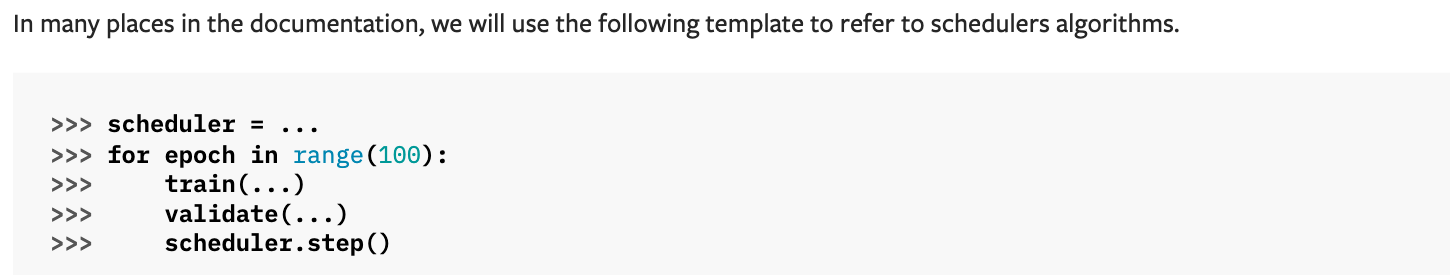

In [15]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min',
                                                 factor=0.5,
                                                 patience=1)

# @@@@@ 3. Training Routine
## 3.1 - Helper function: tracking the training state

In [16]:
def init_train_state(args):
    train_state_dict = {'stop_early': False,
                        'early_stopping_step': 0,
                        'early_stopping_best_val': 1e8,
                        'learning_rate': args.learning_rate,
                        'epoch_index': 0,
                        'train_loss': [],
                        'train_acc': [],
                        'val_loss': [],
                        'val_acc': [],
                        'test_loss': -1,
                        'test_acc': -1,
                        'model_filename': args.save_model_name
                       }
    return train_state_dict

def update_train_state(args, model, train_state):
    """
    Handle the training state updates.
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better
    
    Args:
        args:  arguments
        model: model to train
        train_state: a dictionary representing the training state values
    
    Returns:
        a new train_state
    """

    # Save the first model
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss increased (not a better model)
        if loss_t >= train_state['early_stopping_best_val']:
            # Update early_stopping_step
            train_state['early_stopping_step'] += 1
        # If loss decreased
        else:
            # Save the best model and update the early_stopping_best_val
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        # In the main training loop, if train_state['stop_early']: break
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

In [51]:
train_state = init_train_state(args)
train_state

{'stop_early': False,
 'early_stopping_step': 0,
 'early_stopping_best_val': 100000000.0,
 'learning_rate': 0.001,
 'epoch_index': 0,
 'train_loss': [],
 'train_acc': [],
 'val_loss': [],
 'val_acc': [],
 'test_loss': -1,
 'test_acc': -1,
 'model_filename': 'perceptron_model.pth'}

## 3.2 - Helper function: compute accurary rate

In [18]:
def compute_accuracy(y_pred, y_target, device, apply_sigmoid=True):
    y_target = y_target.to(device)
    if apply_sigmoid:
        y_pred_indices = (torch.sigmoid(y_pred)>0.5).to(device).long()
    else: 
        y_pred_indices = (y_pred>0.5).to(device).long()
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [19]:
sigmoid       = nn.Sigmoid()
outputs       = torch.randn(4, 1, requires_grad=True).squeeze()
probabilities = sigmoid(outputs)
targets       = torch.tensor([1, 1, 1, 1], dtype=torch.float32)
print('targets:', targets)
print('outputs:',outputs)
print('probabilities:',probabilities)
print('accurary rate(using prob):',compute_accuracy(probabilities,targets,
                                                    device='cpu',apply_sigmoid=False))
print('accurary rate(using logit):',compute_accuracy(outputs,targets,
                                                     device='cpu',apply_sigmoid=True))

targets: tensor([1., 1., 1., 1.])
outputs: tensor([ 0.1379, -2.1322, -1.6270, -0.2090], grad_fn=<SqueezeBackward0>)
probabilities: tensor([0.5344, 0.1060, 0.1642, 0.4479], grad_fn=<SigmoidBackward0>)
accurary rate(using prob): 25.0
accurary rate(using logit): 25.0


## 3.3 - Training loop
### - The training loop updates the model parameters so that it improves over time.
### - The training loop is composed of two loops: an inner loop over batches in the dataset, and an outer loop, which repeats the inner loop a number of times.
### - The inner loop (batch), losses are computed for each batch, and the optimizer is used to update the model parameters.

In [54]:
def print_train_state(train_state):
    print('Train Loss:',round(train_state['train_loss'][-1],5))
    print('Train Accuracy:',round(train_state['train_acc'][-1],5))
    print('Valid Loss:',round(train_state['val_loss'][-1],5))
    print('Valid Accuracy:',round(train_state['val_acc'][-1],5))
    print('early_stopping_best_val:',round(train_state['early_stopping_best_val'],5))
    print('early_stopping_step:',train_state['early_stopping_step'])
    print('stop_early:',train_state['stop_early'])

In [60]:
if args.get_model == 'TRAIN':
    ##### Get an initialized train_state
    train_state = init_train_state(args)
    
    for epoch_index in range(args.num_epochs):
        print('-'*60)
        print(f'Epoch {epoch_index}...')
        train_state['epoch_index'] = epoch_index

        ##################################################
        #####     Iterate over training dataset      #####
        ##################################################
        print('Training Iteration...')

        ##### Create a batch_generator using training data
        dataset.set_split('train')
        batch_generator = generate_batches(dataset,
                                           batch_size=args.batch_size,
                                           device=args.device)

        ##### running_loss and running_acc are equivalent to the moving averages of loss and accuracy.
        ##### when the loop ends, a moving average is just an average. 
        ##### In each epoch loop, they are reset to zero before the batch loop.
        running_loss = 0.0
        running_acc  = 0.0

        ##### Indicate that the model is in “training mode” 
        # makes the model parameters mutable 
        # and enables regularization mechanisms like dropout
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:
            # --------------------------------------
            ##### STEP 1. zero the gradients
            # Inside each batch iteration, the optimizer’s gradients are first reset
            # Calling backward (step 4 below) will ACCUMULATE gradients, so if the backward()
            # is called earlier, the new gradient is accumulated on top of the one computed 
            # in previous iterations, which leads ao an incorrect value for the gradient.
            # Therefore, use this zero_ method to reset the gradients.
            optimizer.zero_grad()

            ##### STEP 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'].float())

            ##### STEP 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'].float())
            loss_t = loss.item()
            # update the moving average of loss, batch by batch
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            ##### STEP 4. use loss to produce gradients (gradients are propagated to each parameter)
            # Calling backward() and the gradients at each leaf is ACCUMULATED, not stored.
            # Note that the loss is the loss in train split. There is no valid_loss.backward()
            # because we don't want to train the model on the validation data. 
            loss.backward()

            ##### STEP 5. use optimizer to update parameters
            # the optimizer uses the propagated gradients to perform parameter updates
            # The value of classifier.parameters(), i.e., params is automatically updated in this step. 
            # In specific, the optimizer looks into params.grad and updates params, by substracting 
            # learning_rate * grad from it. 
            optimizer.step()

            ##### Tracking the accuracy
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'],
                                     args.device, apply_sigmoid=True)
            # update the moving average of acc, batch by batch
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        ##### After this inner loop (training) ends
        # Append the running_loss and running_acc to train_state
        # (the average of loss and acc in all the batches in the current epoch)
        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        ##################################################
        #####     Iterate over validation dataset    #####
        ##################################################
        print('Validation Iteration...')

        ##### Create a batch_generator using validation data
        dataset.set_split('val')    
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        ##### Create new running loss, and running accuracy
        running_loss = 0.0
        running_acc  = 0.0

        ##### Indicate that the model is in “evaluation mode”
        # makes the model parameters immutable 
        # disables dropout
        # disables computation of the loss and propagation of gradients back to the parameters
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            ##### compute the output
            y_pred = classifier(x_in=batch_dict['x_data'].float())

            ##### STEP 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'].float())
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            ##### compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'],
                                     args.device, apply_sigmoid=True)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        ##### After this inner loop (validation) ends
        # Append the running_loss and running_acc to train_state
        # (the average of loss and acc in all the batches in the current epoch)
        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        ##### Update the status of Early Stopping and Model Checkpoint
        # Input: the current classifier and current train_state (end of the current epoch loop)
        # Update three items in train_state
        # 1."early_stopping_step" +=1 or reset to 0 (comparing val_loss and early_stopping_best_val)
        # 2."early_stopping_best_val" update to the current val_loss if it is the best model
        # 3."stop_early" if early_stopping_step reaches early_stopping_criteria. If True, break all loops below. 
        # Save a new model if the current model has early_stopping_best_val
        train_state = update_train_state(args = args, model = classifier,
                                         train_state = train_state)
        
        scheduler.step(train_state['val_loss'][-1])
        print('Current lr:', optimizer.param_groups[0]['lr'])

        print_train_state(train_state)

        if train_state['stop_early']:
            break

elif args.get_model == 'LOAD':
    classifier.load_state_dict(torch.load(train_state['model_filename']))
    classifier = classifier.to(args.device)

------------------------------------------------------------
Epoch 0...
Training Iteration...
Validation Iteration...
Current lr: 1.953125e-06
Train Loss: 0.13113
Train Accuracy: 95.5627
Valid Loss: 0.20418
Valid Accuracy: 92.04327
early_stopping_best_val: 100000000.0
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 1...
Training Iteration...
Validation Iteration...
Current lr: 9.765625e-07
Train Loss: 0.13114
Train Accuracy: 95.56526
Valid Loss: 0.20407
Valid Accuracy: 92.11538
early_stopping_best_val: 0.20407
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 2...
Training Iteration...
Validation Iteration...
Current lr: 9.765625e-07
Train Loss: 0.13109
Train Accuracy: 95.56526
Valid Loss: 0.20491
Valid Accuracy: 92.04327
early_stopping_best_val: 0.20407
early_stopping_step: 1
stop_early: False
------------------------------------------------------------
Epoch 3...
Trai

# @@@@@ 4. Evaluation
## 4.1 - Evaluation on Test Data

In [69]:
##### Create a batch_generator using test data
# The test set should be run as little as possible
# Avoid make a new model decision based on the evaluation on test data
# Otherwise the model might be biased toward the test data, and the test data will 
# become meaningless as an measure of truly held-out data.
dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)

##### Create new running loss, and running accuracy
running_loss = 0.0
running_acc = 0.0

##### Indicate that the model is in “evaluation mode”
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = classifier(x_in=batch_dict['x_data'].float())

    # compute the loss
    loss   = loss_func(y_pred, batch_dict['y_target'].float())
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'],
                            args.device, apply_sigmoid=True)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc']  = running_acc
print("Test loss: {:.5f}".format(train_state['test_loss']))
print("Test Accuracy: {:.5f}".format(train_state['test_acc']))

Test loss: 0.21480
Test Accuracy: 91.87500


## 4.2 Generation a prediction for a given review

In [140]:
reviews = {
    'positive': "Exceptional service, delightful ambiance, and the food was simply outstanding!",
    'neutral' : "The ambiance was average, and the menu provided a typical selection of dishes.",
    'negative': "Poor service, bland dishes, and the overall dining experience left much to be desired.",
    'noise'   : "Today is Monday, so the school is open"
 }
reviews

{'positive': 'Exceptional service, delightful ambiance, and the food was simply outstanding!',
 'neutral': 'The ambiance was average, and the menu provided a typical selection of dishes.',
 'negative': 'Poor service, bland dishes, and the overall dining experience left much to be desired.',
 'noise': 'Today is Monday, so the school is open'}

In [141]:
def preprocess_text(text):
    ### converts all characters in the text to lowercase
    text = text.lower()
    ### substitute [.,!?] with spaces before and after matched punctuation marks
    text = re.sub(r"([.,!?])", r" \1 ", text)
    ### replace [^a-zA-Z.,!?] with a single space
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

example_text = "Hello,world!"
print('Example:')
print(f"original: {example_text}")
print(f'poreprocessed: {preprocess_text(example_text)}')
print('-'*60)
example_text = "abc ?!?!? 123"
print('Example:')
print(f"original: {example_text}")
print(f'poreprocessed: {preprocess_text(example_text)}')

Example:
original: Hello,world!
poreprocessed: hello , world ! 
------------------------------------------------------------
Example:
original: abc ?!?!? 123
poreprocessed: abc ? ! ? ! ? 


In [142]:
def predict_review(review, 
                   classifier, 
                   device, 
                   vectorizer, 
                   output_type, 
                   decision_threshold=0.5):
    """Predict the rating of a review
    
    Args:
        review (str): the text of the review
        classifier (ReviewClassifier): the trained model
        device: device
        vectorizer (ReviewVectorizer): the corresponding vectorizer
        output_type: probability, logit, label
        decision_threshold (float): The numerical boundary which separates the rating classes
    """
    
    review = preprocess_text(review)
    classifier = classifier.to(device)
    
    vectorized_review = torch.tensor(vectorizer.vectorize(review))
    ### logit
    logit = classifier(vectorized_review.view(1, -1))
    
    if output_type == 'logit':
        return logit
    elif output_type == 'prob':
        return F.sigmoid(logit).item()
    elif output_type == 'label':
        index = 1
        if probability_value < decision_threshold:
            index = 0
        return vectorizer.rating_vocab.lookup_index(index)
    

In [143]:
prediction = predict_review(reviews['positive'], 
                            classifier,
                            'cpu', 
                            vectorizer, 
                            'prob',
                            decision_threshold=0.5)
print('Review: ',reviews['positive'])
print(f'Prob: {round(prediction,4)}')

Review:  Exceptional service, delightful ambiance, and the food was simply outstanding!
Prob: 0.885


In [144]:
prediction = predict_review(reviews['neutral'], 
                            classifier,
                            'cpu', 
                            vectorizer, 
                            'prob',
                            decision_threshold=0.5)
print('Review: ',reviews['neutral'])
print(f'Prob: {round(prediction,4)}')

Review:  The ambiance was average, and the menu provided a typical selection of dishes.
Prob: 0.4516


In [145]:
prediction = predict_review(reviews['negative'], 
                            classifier,
                            'cpu', 
                            vectorizer, 
                            'prob',
                            decision_threshold=0.5)
print('Review: ',reviews['negative'])
print(f'Prob: {round(prediction,4)}')

Review:  Poor service, bland dishes, and the overall dining experience left much to be desired.
Prob: 0.018


In [146]:
prediction = predict_review(reviews['noise'], 
                            classifier,
                            'cpu', 
                            vectorizer, 
                            'prob',
                            decision_threshold=0.5)
print('Review: ',reviews['noise'])
print(f'Prob: {round(prediction,4)}')

Review:  Today is Monday, so the school is open
Prob: 0.6841


## 4.3 Generation a prediction for a given review
### Weight parameter represents the strength of the connection between units. 

In [147]:
fc1_weights = classifier.fc1.weight.detach()[0]
_, indices = torch.sort(fc1_weights, dim=0, descending=True)
indices = indices.numpy().tolist()

In [151]:
print("Influential words in Positive Reviews:")
print("--------------------------------------")
for i in range(20):
    print(vectorizer.review_vocab.lookup_index(indices[i]))

Influential words in Positive Reviews:
--------------------------------------
worst
mediocre
bland
horrible
meh
awful
rude
terrible
tasteless
overpriced
disgusting
unfriendly
slowest
poorly
unacceptable
nmaybe
downhill
underwhelmed
disappointing
disappointment


In [152]:
# Top 20 negative words
print("Influential words in Negative Reviews:")
print("--------------------------------------")
indices.reverse()
for i in range(20):
    print(vectorizer.review_vocab.lookup_index(indices[i]))

Influential words in Negative Reviews:
--------------------------------------
delicious
pleasantly
fantastic
amazing
great
vegas
ngreat
excellent
yum
perfect
awesome
yummy
love
bomb
chinatown
deliciousness
solid
pleased
hooked
notch
